In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


 

Download the caltech_birds2010 dataset

In [2]:
dataset, info = tfds.load('CaltechBirds2010:0.*.*', with_info=True)

# **U_NET:**

# Preprocessing data


In [3]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

image_size = 256

In [4]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Complete the required items:**

Flip images from right to left

Flip images from up to down

adjust brightness image with delta = 0.5

central crop image with value = 0.5

In [5]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_image = tf.image.flip_up_down(input_image)
    input_image = tf.image.adjust_brightness(input_image , 0.5)
    input_image = tf.image.central_crop(input_image , 0.5)

    input_mask = tf.image.flip_left_right(input_mask)
    input_mask = tf.image.flip_up_down(input_mask)
    input_mask = tf.image.adjust_brightness(input_mask , 0.5)
    input_mask = tf.image.central_crop(input_mask , 0.5)

  input_image = tf.image.resize(datapoint['image'], [256,256])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [256,256])


   
  


  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [256,256])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [256,256])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [8]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

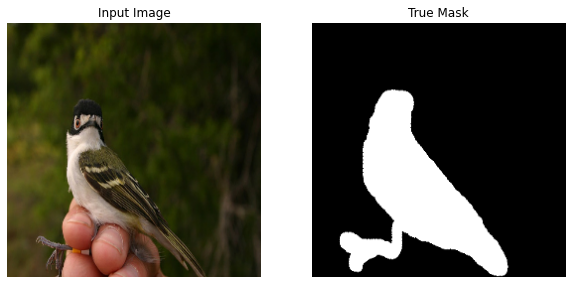

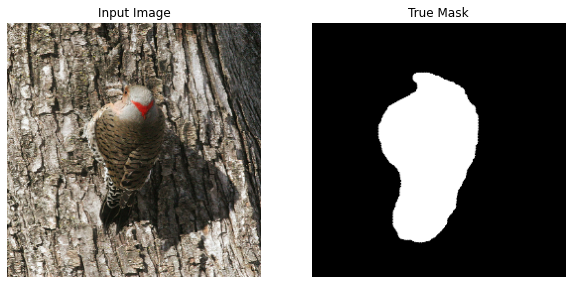

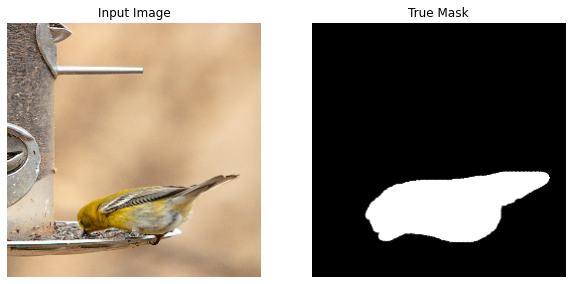

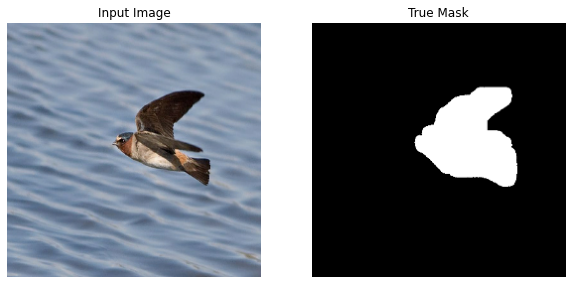

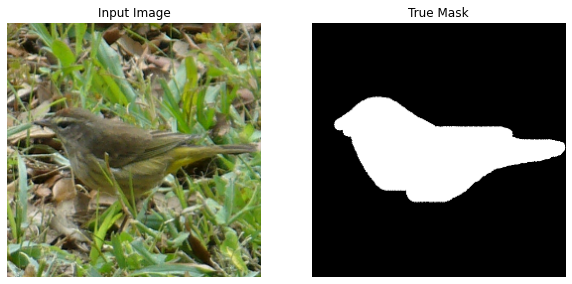

In [26]:
for image, mask in train.take(5):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

# U-net architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
START:| | TS(1,4,2)
CL(32,4,2) |  | TBR(32,4,2)
CBL(64,4,2) |  | TBDR(64,4,2)
CBL(128,4,2) |  | TBR(128,4,2)
CBL(256,4,2) |  | TBDR(256,4,2)
CBL(512,4,2) | CR(512,4,2) | TBDR(512,4,2)


 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.1.5), D=dropout, R=relu,
T=transpose convolution, S=sigmoid. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

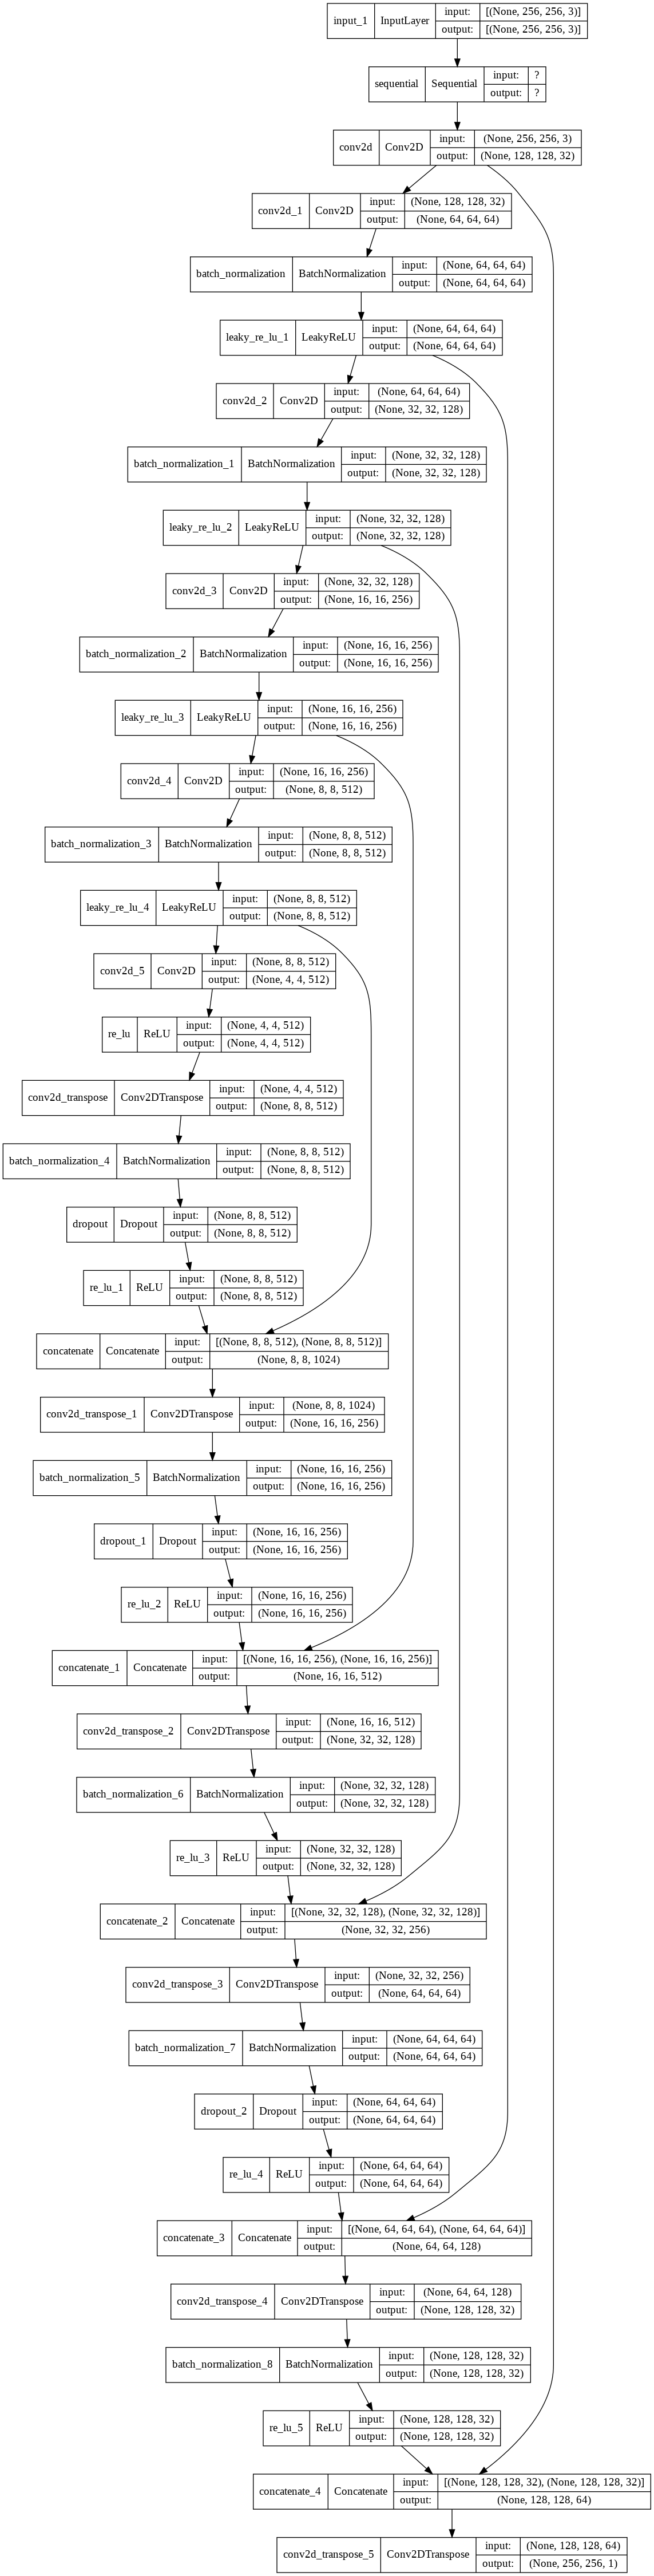

In [10]:
# define an U_Net
def build_model():

  rand1 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  inputs = keras.Input(shape=(256,256,3))
  data_augmentation = keras.Sequential([])
  x = data_augmentation(inputs)

  #Encoder
  conv1 = Conv2D(32, (4, 4), strides = 2, activation= LeakyReLU(alpha=0.15), padding='same')(x)
  conv2 = Conv2D(64, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(conv1)
  x2 = BatchNormalization()(conv2)
  x3 = LeakyReLU(alpha=0.15)(x2)
  conv3 = Conv2D(128, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(x3)
  x4 = BatchNormalization()(conv3)
  x5 = LeakyReLU(alpha=0.15)(x4)
  conv4 = Conv2D(256, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(x5)
  x6 = BatchNormalization()(conv4)
  x7 = LeakyReLU(alpha=0.15)(x6)
  conv5 = Conv2D(512, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(x7)
  x8 = BatchNormalization()(conv5)
  x9 = LeakyReLU(alpha=0.15)(x8)

  #Bottleneck
  conv6 =  Conv2D(512, (4, 4), strides = 2 , activation='relu', padding='same' ,  kernel_initializer=rand1)(x9)
  conv66 = ReLU()(conv6)



  #decoder
  conv7 = Conv2DTranspose(512, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(conv66)
  x10 = BatchNormalization()(conv7)
  x11 = Dropout(0.5)(x10)
  x12 = ReLU()(x11)
  y1 = concatenate([x9 , x12])
  conv8 = Conv2DTranspose(256, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(y1)
  x13 = BatchNormalization()(conv8)
  x14 = Dropout(0.5)(x13)
  x15 = ReLU()(x14)
  y2 = concatenate([x7 , x15])
  conv9 = Conv2DTranspose(128, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(y2)
  x16 = BatchNormalization()(conv9)
  x17 = ReLU()(x16)
  y3 = concatenate([x5 , x17])
  conv10 = Conv2DTranspose(64, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(y3)
  x18 = BatchNormalization()(conv10)
  x19 = Dropout(0.5)(x18)
  x20 = ReLU()(x19)
  y4 = concatenate([x20 , x3])
  conv11 = Conv2DTranspose(32, (4, 4), strides = 2, padding='same',  kernel_initializer=rand1)(y4)
  x21 = BatchNormalization()(conv11)
  x22 = ReLU()(x21)
  y5 = concatenate([x22 , conv1])
  output_layer = Conv2DTranspose(1, (4, 4), strides = 2 , activation='sigmoid', padding='same',  kernel_initializer=rand1)(y5)

  return keras.Model(inputs, output_layer)




model = build_model()
keras.utils.plot_model(model, show_shapes=True)


# Compile:

Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics 

In [37]:
#Compile
model.compile(optimizer= Adam(learning_rate=0.001), loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# Fit the model

In [38]:

EPOCHS = 10
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data

history = model.fit(train_dataset, epochs=EPOCHS,   steps_per_epoch=STEPS_PER_EPOCH,  validation_steps=VALIDATION_STEPS,validation_data=test_dataset)



Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 36s 749ms/step - loss: 0.0000e+00 - accuracy: 0.8275 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 2/10
46/46 [==============================] - 34s 742ms/step - loss: 0.0000e+00 - accuracy: 0.8266 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 3/10
46/46 [==============================] - 35s 759ms/step - loss: 0.0000e+00 - accuracy: 0.8279 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 4/10
46/46 [==============================] - 34s 744ms/step - loss: 0.0000e+00 - accuracy: 0.8260 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 5/10
46/46 [==============================] - 34s 745ms/step - loss: 0.0000e+00 - accuracy: 0.8270 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 6/10
46/46 [==============================] - 34s 743ms/step - loss: 0.0000e+00 - accuracy: 0.8274 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 7/10
46/46 [==============================] - 34s 745ms/step - loss: 0.0000e+00 - accuracy: 0.8286 

# Predict


In [35]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = model.predict(image) 
      display([image[0], mask[0], pred_mask[0]])


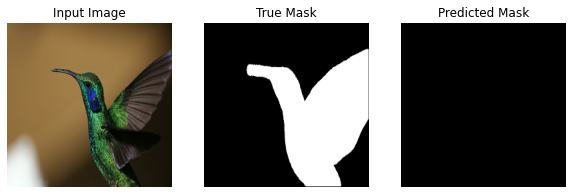

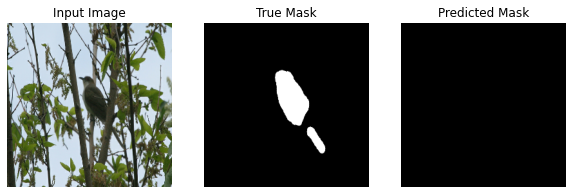

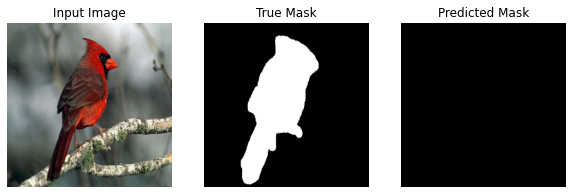

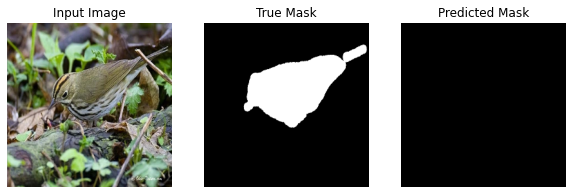

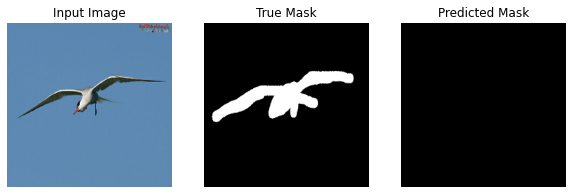

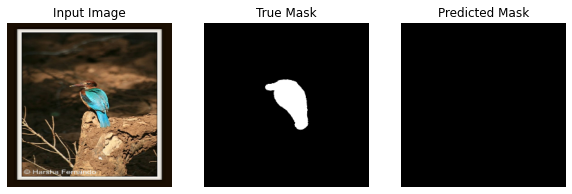

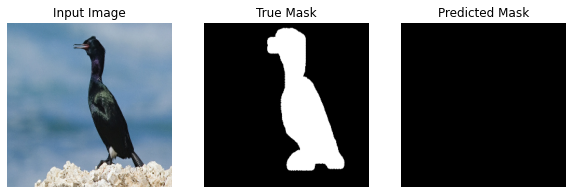

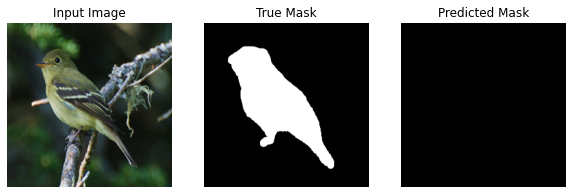

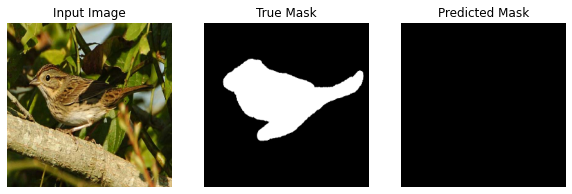

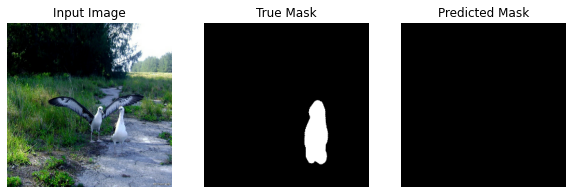

In [36]:
show_predictions(test_dataset)

# **D_LinkNet:**

# Preprocessing data


In [15]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#### put image size ###

image_size = 256

In [16]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Complete the required items:**

Flip images from right to left

Flip images from up to down

adjust brightness image with delta = 0.5

central crop image with value = 0.5

In [21]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_image = tf.image.flip_up_down(input_image)
    input_image = tf.image.adjust_brightness(input_image , 0.5)
    input_image = tf.image.central_crop(input_image , 0.5)

    input_mask = tf.image.flip_left_right(input_mask)
    input_mask = tf.image.flip_up_down(input_mask)
    input_mask = tf.image.adjust_brightness(input_mask , 0.5)
    input_mask = tf.image.central_crop(input_mask , 0.5)

  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
    

    #### put your code ###
    

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [22]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [23]:

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [24]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

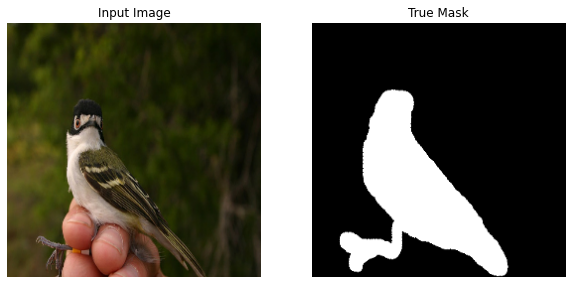

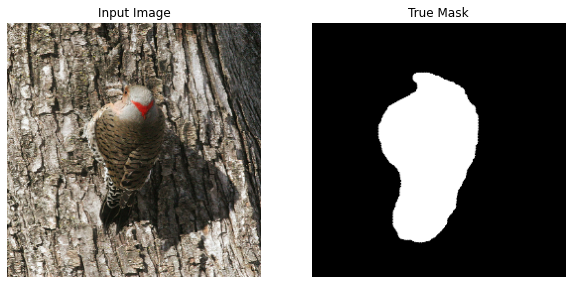

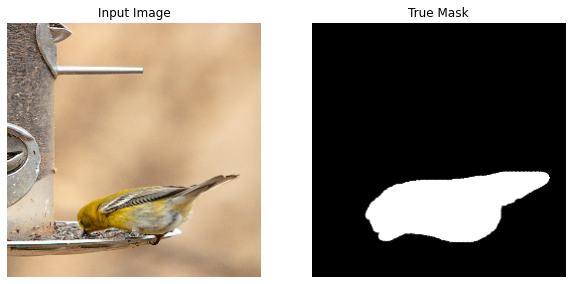

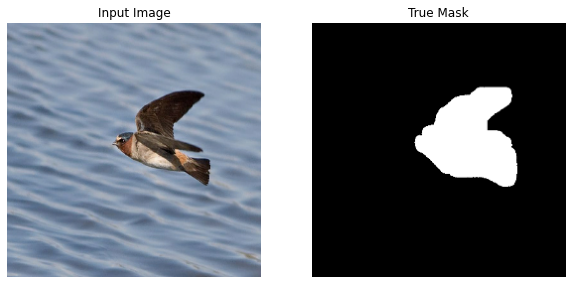

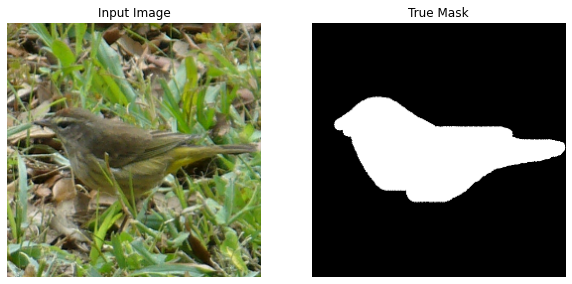

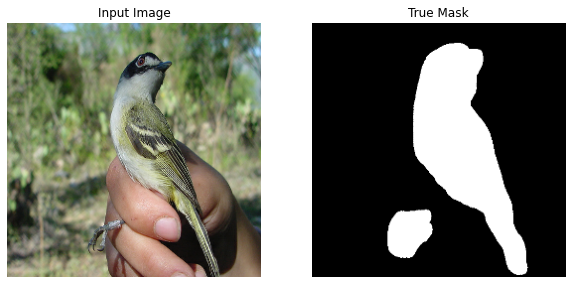

In [25]:
for image, mask in train.take(6):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

# D_linknet architecture:

https://sci-hub.se/10.1109/CVPRW.2018.00034



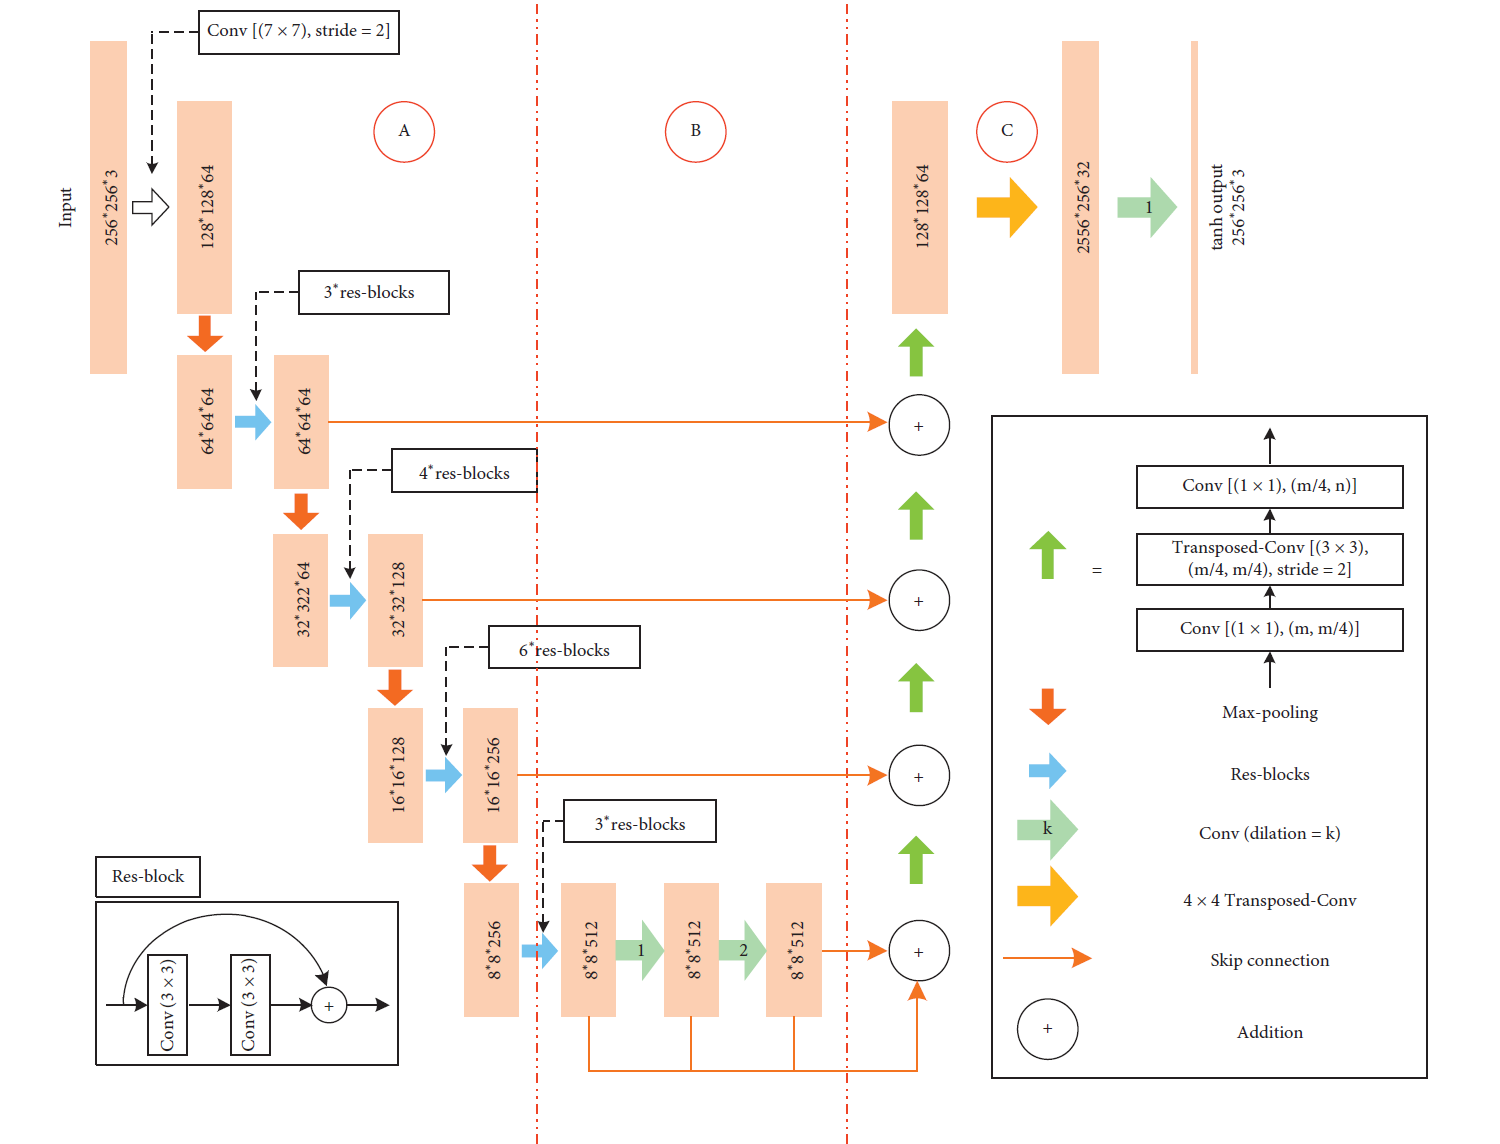


You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/


In [27]:
# function for creating an identity or projection residual module
def residual_block(x,filters,kernel_size =3 ,down_sample=False):
  y = Conv2D(filters=filters,kernel_size=kernel_size,strides=(1 if not down_sample else 2),padding='same',activation='relu')(x)
  y = Conv2D(filters=filters,kernel_size=kernel_size,padding='same')(y)
  if down_sample:
    x = Conv2D(filters=filters,kernel_size=1,strides=2,padding='same')(x)
  xy = Add()([x,y])
  out = Activation('relu')(xy)
  return out

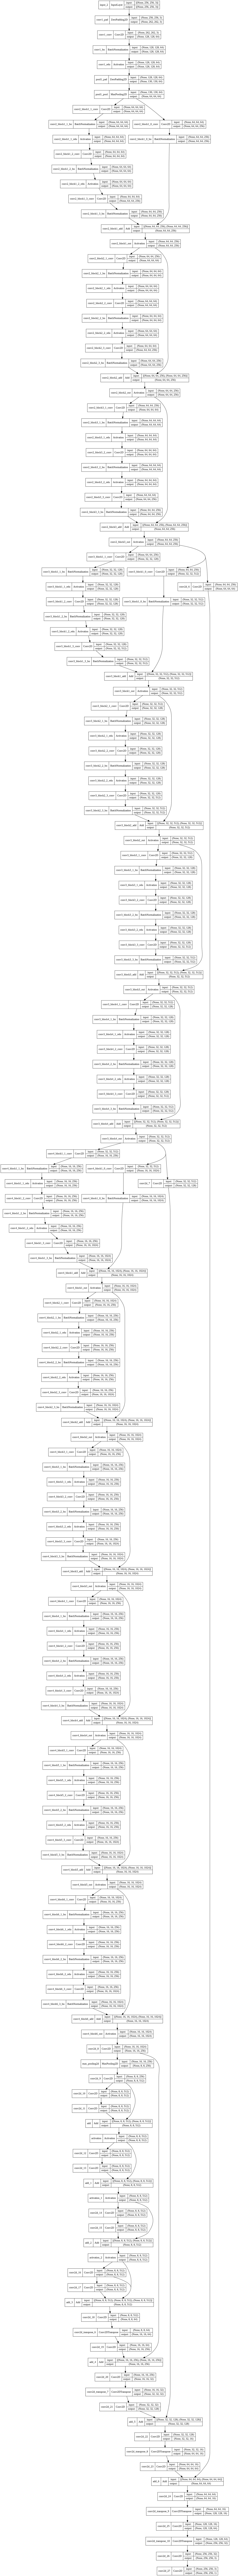

In [28]:

res50 = tf.keras.applications.ResNet50(include_top=False,weights=None,input_shape=(256,256,3))


#resnet section
x3 =res50.get_layer('conv2_block3_out').output
x3 = Conv2D(64, (1, 1),  padding='same')(x3)

x2= res50.get_layer('conv3_block4_out').output
x2 = Conv2D(128, (1, 1),  padding='same')(x2)

x1 = res50.get_layer('conv4_block6_out').output
x1 = Conv2D(256, (1, 1),  padding='same')(x1)

#neck
x = MaxPooling2D()(x1)
x = Conv2D(512 , (1,1) , padding='same')(x)
x=residual_block(x ,512 ,3)
x=residual_block(x ,512 , 3)
y4=residual_block(x ,512 , 3)
Dilation_1 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',dilation_rate=1)(y4) 
Dilation_2 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',dilation_rate=2)(Dilation_1) 
z1 = add([Dilation_2 , Dilation_1 , y4])

#decode
z1 = Conv2D(64 , (1,1) , padding='same')(z1)
z1 =  Conv2DTranspose(64, (3, 3), strides = 2, padding='same')(z1)
z1 = Conv2D(256 , (1,1) , padding='same')(z1)



z2 = add([z1 , x1])
z2 = Conv2D(32 , (1,1) , padding='same')(z2)
z2 =  Conv2DTranspose(32, (3, 3), strides = 2, padding='same')(z2)
z2 = Conv2D(128 , (1,1) , padding='same')(z2)



z3 = add([z2 , x2])
z3 = Conv2D(16 , (1,1) , padding='same')(z3)
z3 =  Conv2DTranspose(16, (3, 3), strides = 2, padding='same')(z3)
z3 = Conv2D(64 , (1,1) , padding='same')(z3)



z4 = add([z3 , x3])
z4 = Conv2D(16 , (1,1) , padding='same')(z4)
z4 =  Conv2DTranspose(16, (3, 3), strides = 2, padding='same')(z4)
z4 = Conv2D(64 , (1,1) , padding='same')(z4)


z5 = Conv2DTranspose(32, (4, 4), strides = 2, padding='same')(z4)

z5 = Conv2D(3 , (1,1) , padding='same' , activation = 'tanh',dilation_rate=1)(z5)
outputs = Conv2D(1 , (1,1) , padding='same', activation = 'tanh')(z5)

model3 = keras.models.Model(res50.layers[0].input , outputs)

keras.utils.plot_model(model3, show_shapes=True)

In [ ]:
    #without resnet50
    
    # x = Conv2D(64, 7, strides = 2, padding="same", activation = "relu")(x)
    # x =MaxPooling2D()(x)
    # x=residual_block(x ,64 ,3)
    # x=residual_block(x ,64 , 3)
    # y1=residual_block(x ,64 , 3)
    # x =MaxPooling2D()(y1)
    # x = Conv2D(128 , (1,1) , padding='same')(x)
    # x=residual_block(x ,128 ,3)
    # x=residual_block(x ,128 , 3)
    # x=residual_block(x ,128 , 3)
    # y2=residual_block(x ,128 , 3)
    # x =MaxPooling2D()(y2)
    # x = Conv2D(256 , (1,1) , padding='same')(x)
    # x=residual_block(x ,256 ,3)
    # x=residual_block(x ,256 , 3)
    # x=residual_block(x ,256 , 3)
    # y3=residual_block(x ,256 , 3)
    # x =MaxPooling2D()(y3)
    # x = Conv2D(512 , (1,1) , padding='same')(x)
    # x=residual_block(x ,512 ,3)
    # x=residual_block(x ,512 , 3)
    # y4=residual_block(x ,512 , 3)
    # Dilation_1 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',dilation_rate=1)(y4) # C2
    # Dilation_2 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',dilation_rate=2)(Dilation_1) # C3
    # z1 = add([Dilation_2 , Dilation_1 , y4])
    # z1 = Conv2D(64 , (1,1) , padding='same')(z1)
    # z1 =  Conv2DTranspose(64, (3, 3), strides = 2, padding='same')(z1)
    # z1 = Conv2D(256 , (1,1) , padding='same')(z1)

    # z2 = add([z1 , y3])
    # z2 = Conv2D(32 , (1,1) , padding='same')(z2)
    # z2 =  Conv2DTranspose(32, (3, 3), strides = 2, padding='same')(z2)
    # z2 = Conv2D(128 , (1,1) , padding='same')(z2)

    # z3 = add([z2 , y2])
    # z3 = Conv2D(16 , (1,1) , padding='same')(z3)
    # z3 =  Conv2DTranspose(16, (3, 3), strides = 2, padding='same')(z3)
    # z3 = Conv2D(64 , (1,1) , padding='same')(z3)

    # z4 = add([z3 , y1])
    # z4 = Conv2D(16 , (1,1) , padding='same')(z4)
    # z4 =  Conv2DTranspose(16, (3, 3), strides = 2, padding='same')(z4)
    # z4 = Conv2D(64 , (1,1) , padding='same')(z4)

    # z5 = Conv2DTranspose(32, (4, 4), strides = 2, padding='same')(z4)

    # outputs = Conv2D(1 , (1,1) , padding='same')(z5)

# Compile the model
Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics

In [29]:
#Compile

model3.compile(optimizer= Adam(learning_rate=0.001), loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# Fit the model

In [30]:
EPOCHS = 20
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
history = model3.fit(train_dataset, epochs=EPOCHS,   steps_per_epoch=STEPS_PER_EPOCH,  validation_steps=VALIDATION_STEPS,validation_data=test_dataset)


Epoch 1/20
46/46 [==============================] - 117s 2s/step - loss: 0.0000e+00 - accuracy: 0.8150 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 2/20
46/46 [==============================] - 98s 2s/step - loss: 0.0000e+00 - accuracy: 0.8273 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 3/20
46/46 [==============================] - 91s 2s/step - loss: 0.0000e+00 - accuracy: 0.8264 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 4/20
46/46 [==============================] - 91s 2s/step - loss: 0.0000e+00 - accuracy: 0.8268 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 5/20
46/46 [==============================] - 91s 2s/step - loss: 0.0000e+00 - accuracy: 0.8284 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 6/20
46/46 [==============================] - 91s 2s/step - loss: 0.0000e+00 - accuracy: 0.8255 - val_loss: 0.0000e+00 - val_accuracy: 0.8362
Epoch 7/20
46/46 [==============================] - 91s 2s/step - loss: 0.0000e+00 - accuracy: 0.8284 - val_los

# Predict


In [31]:
def show_predictions2(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = model3.predict(image) 
      display([image[0], mask[0], pred_mask[0]])

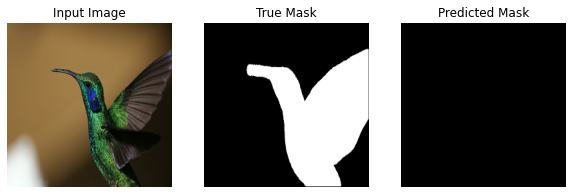

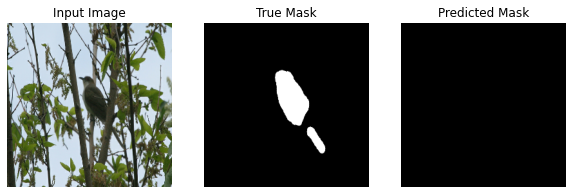

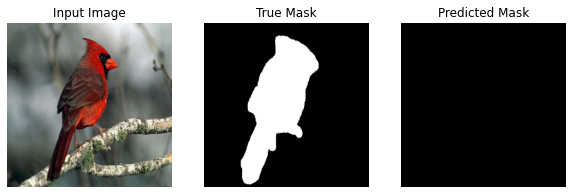

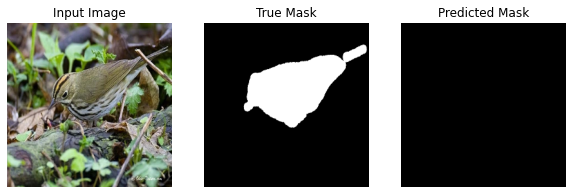

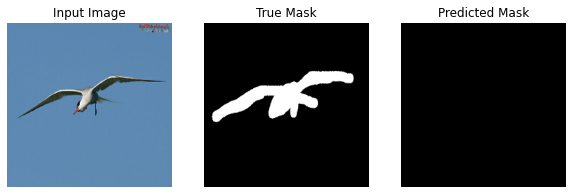

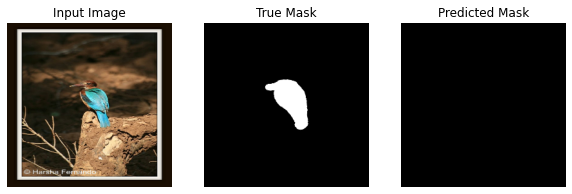

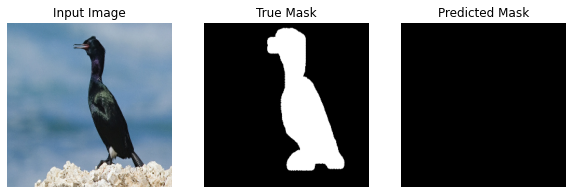

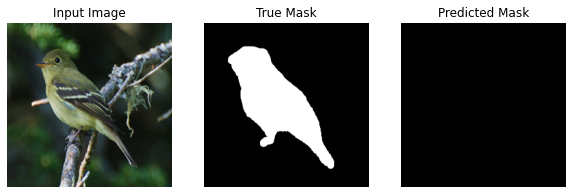

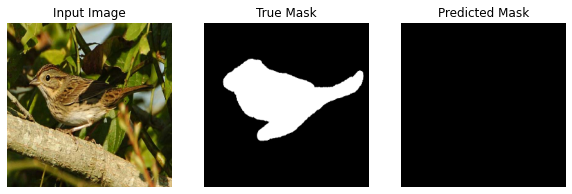

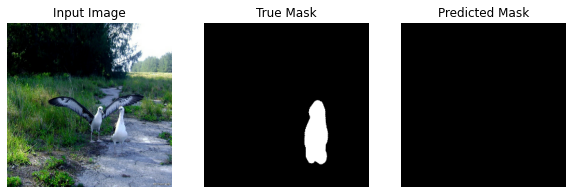

In [32]:
show_predictions2(test_dataset)